In [1]:
"""
Created on 20 dec. 2010

This file illustrated the use of the workbench for a model
specified in Python itself. The example is based on `Pruyt & Hamarat <https://www.systemdynamics.org/conferences/2010/proceed/papers/P1253.pdf>`_.
For comparison, run both this model and the flu_vensim_no_policy_example.py and
compare the results.


.. codeauthor:: jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>
                chamarat <c.hamarat  (at) tudelft (dot) nl>

"""

import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, min, exp

from ema_workbench import Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import lines, Density

# =============================================================================
#
#    the model itself
#
# =============================================================================

FINAL_TIME = 24 # 48
INITIAL_TIME = 0
TIME_STEP = 0.0078125

switch_regions = 1.0
switch_immunity = 1.0
switch_deaths = 1.0
switch_immunity_cap = 1.0


def LookupFunctionX(variable, start, end, step, skew, growth, v=0.5):
    return start + ((end - start) / ((1 + skew * exp(-growth * (variable - step))) ** (1 / v)))


def flu_model(
    x11=0,
    x12=0,
    x21=0,
    x22=0,
    x31=0,
    x32=0,
    x41=0,
    x51=0,
    x52=0,
    x61=0,
    x62=0,
    x81=0,
    x82=0,
    x91=0,
    x92=0,
    x101=0,
    x102=0,
):
    # Assigning initial values
    additional_seasonal_immune_population_fraction_R1 = float(x11)
    additional_seasonal_immune_population_fraction_R2 = float(x12)

    fatality_rate_region_1 = float(x21)
    fatality_rate_region_2 = float(x22)

    initial_immune_fraction_of_the_population_of_region_1 = float(x31)
    initial_immune_fraction_of_the_population_of_region_2 = float(x32)

    normal_interregional_contact_rate = float(x41)
    interregional_contact_rate = switch_regions * normal_interregional_contact_rate

    permanent_immune_population_fraction_R1 = float(x51)
    permanent_immune_population_fraction_R2 = float(x52)

    recovery_time_region_1 = float(x61)
    recovery_time_region_2 = float(x62)

    susceptible_to_immune_population_delay_time_region_1 = 1
    susceptible_to_immune_population_delay_time_region_2 = 1

    root_contact_rate_region_1 = float(x81)
    root_contact_rate_region_2 = float(x82)

    infection_rate_region_1 = float(x91)
    infection_rate_region_2 = float(x92)

    normal_contact_rate_region_1 = float(x101)
    normal_contact_rate_region_2 = float(x102)

    ######
    susceptible_to_immune_population_flow_region_1 = 0.0
    susceptible_to_immune_population_flow_region_2 = 0.0
    ######

    initial_value_population_region_1 = 6.0 * 10**8
    initial_value_population_region_2 = 3.0 * 10**9

    initial_value_infected_population_region_1 = 10.0
    initial_value_infected_population_region_2 = 10.0

    initial_value_immune_population_region_1 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_1
        * initial_value_population_region_1
    )
    initial_value_immune_population_region_2 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_2
        * initial_value_population_region_2
    )

    initial_value_susceptible_population_region_1 = (
        initial_value_population_region_1 - initial_value_immune_population_region_1
    )
    initial_value_susceptible_population_region_2 = (
        initial_value_population_region_2 - initial_value_immune_population_region_2
    )

    recovered_population_region_1 = 0.0
    recovered_population_region_2 = 0.0

    infected_population_region_1 = initial_value_infected_population_region_1
    infected_population_region_2 = initial_value_infected_population_region_2

    susceptible_population_region_1 = initial_value_susceptible_population_region_1
    susceptible_population_region_2 = initial_value_susceptible_population_region_2

    immune_population_region_1 = initial_value_immune_population_region_1
    immune_population_region_2 = initial_value_immune_population_region_2

    deceased_population_region_1 = [0.0]
    deceased_population_region_2 = [0.0]
    runTime = [INITIAL_TIME]

    # --End of Initialization--

    Max_infected = 0.0

    for time in range(int(INITIAL_TIME / TIME_STEP), int(FINAL_TIME / TIME_STEP)):
        runTime.append(runTime[-1] + TIME_STEP)
        total_population_region_1 = (
            infected_population_region_1
            + recovered_population_region_1
            + susceptible_population_region_1
            + immune_population_region_1
        )
        total_population_region_2 = (
            infected_population_region_2
            + recovered_population_region_2
            + susceptible_population_region_2
            + immune_population_region_2
        )

        infected_population_region_1 = max(0, infected_population_region_1)
        infected_population_region_2 = max(0, infected_population_region_2)

        infected_fraction_region_1 = infected_population_region_1 / total_population_region_1
        infected_fraction_region_2 = infected_population_region_2 / total_population_region_2

        impact_infected_population_on_contact_rate_region_1 = 1 - (
            infected_fraction_region_1 ** (1 / root_contact_rate_region_1)
        )
        impact_infected_population_on_contact_rate_region_2 = 1 - (
            infected_fraction_region_2 ** (1 / root_contact_rate_region_2)
        )

        #        if ((time*TIME_STEP) >= 4) and ((time*TIME_STEP)<=10):
        #            normal_contact_rate_region_1 = float(x101)*(1 - 0.5)
        #        else:normal_contact_rate_region_1 = float(x101)

        normal_contact_rate_region_1 = float(x101) * (
            1 - LookupFunctionX(infected_fraction_region_1, 0, 1, 0.15, 0.75, 15)
        )

        contact_rate_region_1 = (
            normal_contact_rate_region_1 * impact_infected_population_on_contact_rate_region_1
        )
        contact_rate_region_2 = (
            normal_contact_rate_region_2 * impact_infected_population_on_contact_rate_region_2
        )

        recoveries_region_1 = (
            (1 - (fatality_rate_region_1 * switch_deaths))
            * infected_population_region_1
            / recovery_time_region_1
        )
        recoveries_region_2 = (
            (1 - (fatality_rate_region_2 * switch_deaths))
            * infected_population_region_2
            / recovery_time_region_2
        )

        flu_deaths_region_1 = (
            fatality_rate_region_1
            * switch_deaths
            * infected_population_region_1
            / recovery_time_region_1
        )
        flu_deaths_region_2 = (
            fatality_rate_region_2
            * switch_deaths
            * infected_population_region_2
            / recovery_time_region_2
        )

        infections_region_1 = (
            susceptible_population_region_1
            * contact_rate_region_1
            * infection_rate_region_1
            * infected_fraction_region_1
        ) + (
            susceptible_population_region_1
            * interregional_contact_rate
            * infection_rate_region_1
            * infected_fraction_region_2
        )
        infections_region_2 = (
            susceptible_population_region_2
            * contact_rate_region_2
            * infection_rate_region_2
            * infected_fraction_region_2
        ) + (
            susceptible_population_region_2
            * interregional_contact_rate
            * infection_rate_region_2
            * infected_fraction_region_1
        )

        infected_population_region_1_NEXT = infected_population_region_1 + (
            TIME_STEP * (infections_region_1 - flu_deaths_region_1 - recoveries_region_1)
        )
        infected_population_region_2_NEXT = infected_population_region_2 + (
            TIME_STEP * (infections_region_2 - flu_deaths_region_2 - recoveries_region_2)
        )

        if infected_population_region_1_NEXT < 0 or infected_population_region_2_NEXT < 0:
            pass

        recovered_population_region_1_NEXT = recovered_population_region_1 + (
            TIME_STEP * recoveries_region_1
        )
        recovered_population_region_2_NEXT = recovered_population_region_2 + (
            TIME_STEP * recoveries_region_2
        )

        if fatality_rate_region_1 >= 0.025:
            qw = 1.0
        elif fatality_rate_region_1 >= 0.01:
            qw = 0.8
        elif fatality_rate_region_1 >= 0.001:
            qw = 0.6
        elif fatality_rate_region_1 >= 0.0001:
            qw = 0.4
        else:
            qw = 0.2

        if (time * TIME_STEP) <= 10:
            normal_immune_population_fraction_region_1 = (
                additional_seasonal_immune_population_fraction_R1 / 2
            ) * sin(4.5 + (time * TIME_STEP / 2)) + (
                (
                    (2 * permanent_immune_population_fraction_R1)
                    + additional_seasonal_immune_population_fraction_R1
                )
                / 2
            )
        else:
            normal_immune_population_fraction_region_1 = max(
                (
                    float(qw),
                    (additional_seasonal_immune_population_fraction_R1 / 2)
                    * sin(4.5 + (time * TIME_STEP / 2))
                    + (
                        (
                            (2 * permanent_immune_population_fraction_R1)
                            + additional_seasonal_immune_population_fraction_R1
                        )
                        / 2
                    ),
                )
            )

        normal_immune_population_fraction_region_2 = switch_immunity_cap * min(
            (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                ),
                (
                    permanent_immune_population_fraction_R1
                    + additional_seasonal_immune_population_fraction_R1
                ),
            ),
        ) + (
            (1 - switch_immunity_cap)
            * (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                )
            )
        )

        normal_immune_population_region_1 = (
            normal_immune_population_fraction_region_1 * total_population_region_1
        )
        normal_immune_population_region_2 = (
            normal_immune_population_fraction_region_2 * total_population_region_2
        )

        if switch_immunity == 1:
            susminreg1_1 = (
                normal_immune_population_region_1 - immune_population_region_1
            ) / susceptible_to_immune_population_delay_time_region_1
            susminreg1_2 = (
                susceptible_population_region_1
                / susceptible_to_immune_population_delay_time_region_1
            )
            susmaxreg1 = -(
                immune_population_region_1 / susceptible_to_immune_population_delay_time_region_1
            )
            if (susmaxreg1 >= susminreg1_1) or (susmaxreg1 >= susminreg1_2):
                susceptible_to_immune_population_flow_region_1 = susmaxreg1
            elif (susminreg1_1 < susminreg1_2) and (susminreg1_1 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_1
            elif (susminreg1_2 < susminreg1_1) and (susminreg1_2 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_2
        else:
            susceptible_to_immune_population_flow_region_1 = 0

        if switch_immunity == 1:
            susminreg2_1 = (
                normal_immune_population_region_2 - immune_population_region_2
            ) / susceptible_to_immune_population_delay_time_region_2
            susminreg2_2 = (
                susceptible_population_region_2
                / susceptible_to_immune_population_delay_time_region_2
            )
            susmaxreg2 = -(
                immune_population_region_2 / susceptible_to_immune_population_delay_time_region_2
            )
            if (susmaxreg2 >= susminreg2_1) or (susmaxreg2 >= susminreg2_2):
                susceptible_to_immune_population_flow_region_2 = susmaxreg2
            elif (susminreg2_1 < susminreg2_2) and (susminreg2_1 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_1
            elif (susminreg2_2 < susminreg2_1) and (susminreg2_2 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_2
        else:
            susceptible_to_immune_population_flow_region_2 = 0

        susceptible_population_region_1_NEXT = susceptible_population_region_1 - (
            TIME_STEP * (infections_region_1 + susceptible_to_immune_population_flow_region_1)
        )
        susceptible_population_region_2_NEXT = susceptible_population_region_2 - (
            TIME_STEP * (infections_region_2 + susceptible_to_immune_population_flow_region_2)
        )

        immune_population_region_1_NEXT = immune_population_region_1 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_1
        )
        immune_population_region_2_NEXT = immune_population_region_2 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_2
        )

        deceased_population_region_1_NEXT = deceased_population_region_1[-1] + (
            TIME_STEP * flu_deaths_region_1
        )
        deceased_population_region_2_NEXT = deceased_population_region_2[-1] + (
            TIME_STEP * flu_deaths_region_2
        )

        # Updating integral values
        if Max_infected < (
            infected_population_region_1_NEXT
            / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )
        ):
            Max_infected = infected_population_region_1_NEXT / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )

        recovered_population_region_1 = recovered_population_region_1_NEXT
        recovered_population_region_2 = recovered_population_region_2_NEXT

        infected_population_region_1 = infected_population_region_1_NEXT
        infected_population_region_2 = infected_population_region_2_NEXT

        susceptible_population_region_1 = susceptible_population_region_1_NEXT
        susceptible_population_region_2 = susceptible_population_region_2_NEXT

        immune_population_region_1 = immune_population_region_1_NEXT
        immune_population_region_2 = immune_population_region_2_NEXT

        deceased_population_region_1.append(deceased_population_region_1_NEXT)
        deceased_population_region_2.append(deceased_population_region_2_NEXT)

        # End of main code

    return {"TIME": runTime, "deceased_population_region_1": deceased_population_region_1}


if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    model = Model("mexicanFlu", function=flu_model)
    model.uncertainties = [
        RealParameter("x11", 0, 0.5),
        RealParameter("x12", 0, 0.5),
        RealParameter("x21", 0.0001, 0.1),
        RealParameter("x22", 0.0001, 0.1),
        RealParameter("x31", 0, 0.5),
        RealParameter("x32", 0, 0.5),
        RealParameter("x41", 0, 0.9),
        RealParameter("x51", 0, 0.5),
        RealParameter("x52", 0, 0.5),
        RealParameter("x61", 0, 0.8),
        RealParameter("x62", 0, 0.8),
        RealParameter("x81", 1, 10),
        RealParameter("x82", 1, 10),
        RealParameter("x91", 0, 0.1),
        RealParameter("x92", 0, 0.1),
        RealParameter("x101", 0, 200),
        RealParameter("x102", 0, 200),
    ]

    model.outcomes = [TimeSeriesOutcome("TIME"), TimeSeriesOutcome("deceased_population_region_1")]

    nr_experiments = 500

    with SequentialEvaluator(model) as evaluator:
        results = perform_experiments(model, nr_experiments, evaluator=evaluator)

    print("laat")




Bad key text.latex.preview in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pfoytik/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qua

laat


In [2]:
experiments, outcomes = results
outcomes.keys()

dict_keys(['TIME', 'deceased_population_region_1'])

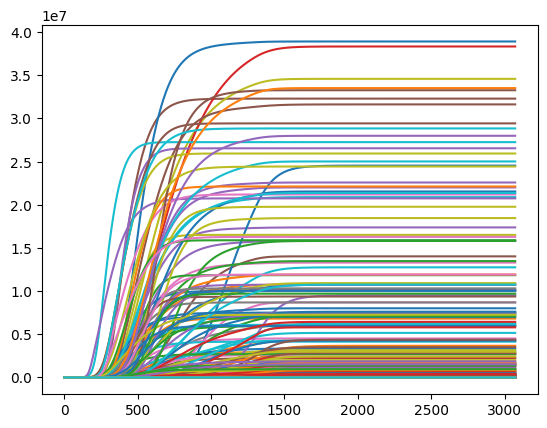

In [3]:
### plot each outcomes['deceased_population_region_1']
for i in range(0, 500):
    plt.plot(outcomes['deceased_population_region_1'][i])


In [25]:
### print the max value of each outcomes['deceased_population_region_1']
for i in range(0, 500):
    print(max(outcomes['deceased_population_region_1'][i]))

    

1.0055208914548128
257.0478567231235
1518204.9537928263
0.8644161050935514
0.91091612652696
153330.04671730183
0.029977315648569064
30097.926037264966
2.4127317748859567
20886575.604873188
10741968.874896728
10788724.008143505
1.0440726006260055
0.5093500141165582
15.84795923917186
14025226.728287127
5.625416083517324
7.0813044498592586
0.38310604928677
321317.5152836754
4.445741719700238
0.6445104178701565
18.661246741326707
0.20371169045485998
22006579.971989088
32292716.507511124
1.6973793025300283
0.8607152738039676
0.6970130287439525
0.7868443274438113
1.387574301255408
0.13212323204042337
1077440.5901833915
4742.357146485304
1465.203145419458
0.5079300215252095
13303615.464440238
7.424289018254235
155420.09724618995
0.4848079458517072
10012152.536147362
0.3929173947272387
0.01109529123481715
0.5144334589546296
18.23914176394465
1464419.0569435777
2049.3878699459406
251.71531799679116
34582445.22779432
139.48502468580662
1467.265256884872
0.0700657813674884
11846309.3806699
0.1409

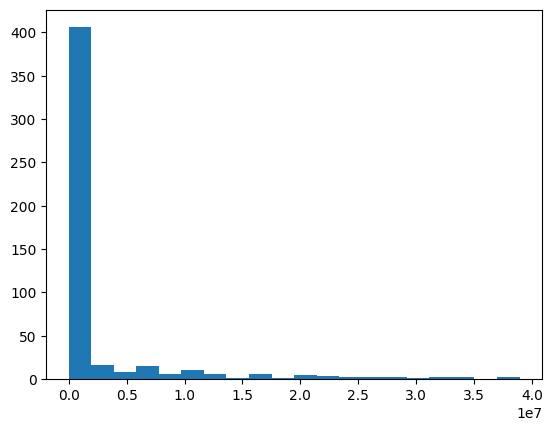

In [26]:
### This plots a histogram of the max number of deceased people in region 1
plt.hist([max(outcomes['deceased_population_region_1'][i]) for i in range(0, 500)], bins=20)
plt.show()



In [22]:
### count how many outcomes['deceased_population_region_1'] are greater than 1
count = 0
for i in deceased_population_region_1:
    if i > 1:
        count += 1

print(count)

380


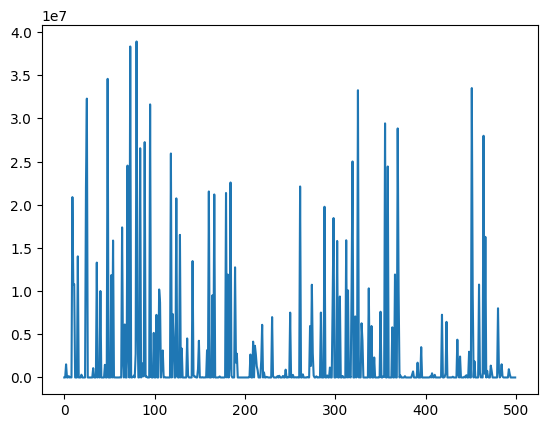

In [4]:

### get the max of each outcomes['deceased_population_region_1']
maxes = []
for i in range(0, 500):
    maxes.append(max(outcomes['deceased_population_region_1'][i]))

### plot the maxes
plt.plot(maxes)


In [5]:
### get the top five maxes indexes
top_five_maxes = sorted(range(len(maxes)), key=lambda i: maxes[i])[-5:]
top_five_maxes


[325, 451, 48, 73, 80]

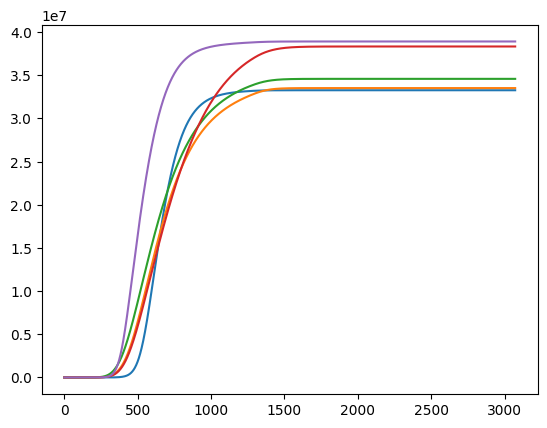

In [6]:
### plot the top five maxes outcomes['deceased_population_region_1']
for i in top_five_maxes:
    plt.plot(outcomes['deceased_population_region_1'][i])

In [60]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes["deceased_population_region_1"][:,-1]

### creat full_y that contains true or false for each row that has a max value greater than 100
full_y = y > 100

### create an array that contains for each full_y if it contains a true value, append True
#y = full_y.any(axis=1)



#y = outcomes["max_P"]


In [61]:
print(len(y), len(x))
print(len(full_y))
full_y

500 500
500


array([False,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False, False,  True,  True, False,  True,
       False,  True,  True, False,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True, False,  True,
        True, False, False,  True, False, False,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False, False,

0.8644161050935514

In [62]:
### get set x to the instances where full_y is True
high_x = x[full_y]
high_y = y[full_y]

print(len(high_x), len(high_y))

277 277


In [63]:
high_y

array([2.57047857e+02, 1.51820495e+06, 1.53330047e+05, 3.00979260e+04,
       2.08865756e+07, 1.07419689e+07, 1.07887240e+07, 1.40252267e+07,
       3.21317515e+05, 2.20065800e+07, 3.22927165e+07, 1.07744059e+06,
       4.74235715e+03, 1.46520315e+03, 1.33036155e+07, 1.55420097e+05,
       1.00121525e+07, 1.46441906e+06, 2.04938787e+03, 2.51715318e+02,
       3.45824452e+07, 1.39485025e+02, 1.46726526e+03, 1.18463094e+07,
       1.58580331e+07, 1.41909538e+04, 7.75648256e+02, 3.11197805e+03,
       3.70366669e+04, 1.73790381e+07, 2.21993110e+06, 6.13848426e+06,
       2.45360345e+07, 2.92608605e+06, 3.83301143e+07, 1.05435557e+04,
       4.11402858e+04, 2.26987561e+05, 2.73916949e+06, 3.89102238e+07,
       6.81795147e+06, 1.77783631e+04, 2.65435525e+07, 2.37998995e+03,
       1.65440377e+06, 1.10846051e+05, 1.99701289e+05, 2.72525479e+07,
       9.06090853e+04, 1.22774212e+05, 3.68468657e+03, 3.16234438e+07,
       5.11611591e+04, 2.28079773e+02, 5.16277657e+06, 7.25249908e+06,
      

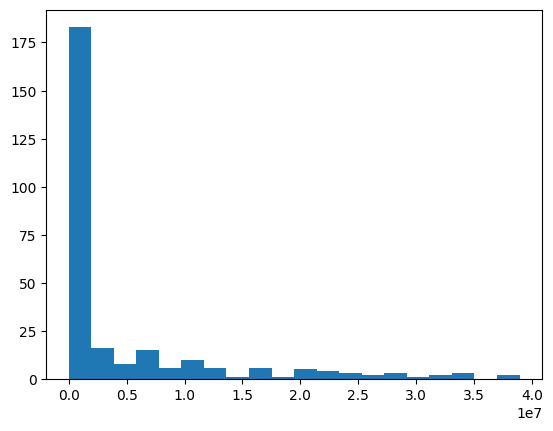

In [64]:
### normalize high_y to be between 0 and 1


### plot histogram of high_y
plt.hist(high_y, bins=20)
plt.show()

In [58]:
### normalize each value of high_y to be between 0 and 1
norm_y = []
for i in high_y:
    norm_y.append((i - min(high_y)) / (max(high_y) - min(high_y)))

norm_y



[3.623477282268699e-06,
 0.039015283791541115,
 0.00393763979726341,
 0.0007705418929314291,
 0.5367875022753115,
 0.27606844187545804,
 0.2772700610937713,
 0.3604490320127724,
 0.008254961910318498,
 0.5655719090059672,
 0.8299283226224201,
 0.027687523751477164,
 0.0001188971054037053,
 3.4673385876088866e-05,
 0.34190343279026336,
 0.003991354645417134,
 0.2573119700704995,
 0.037632972099963885,
 4.9687086902904835e-05,
 3.486429634855517e-06,
 0.8887749527987068,
 6.020815867466342e-07,
 3.472638268296497e-05,
 0.3044502832509244,
 0.4075526384263307,
 0.0003617285235132913,
 1.695164391153787e-05,
 7.699593390468562e-05,
 0.0009488693577534599,
 0.44664286691717947,
 0.057049830350535055,
 0.15775767686592332,
 0.6305795557818609,
 0.07519819822829336,
 0.9850910338447151,
 0.000267989434353813,
 0.0010543334410535767,
 0.005830657287628274,
 0.07039439341483544,
 1.0,
 0.1752201628773609,
 0.00045392588582561386,
 0.682173296990222,
 5.81836473013206e-05,
 0.04251562916528274,


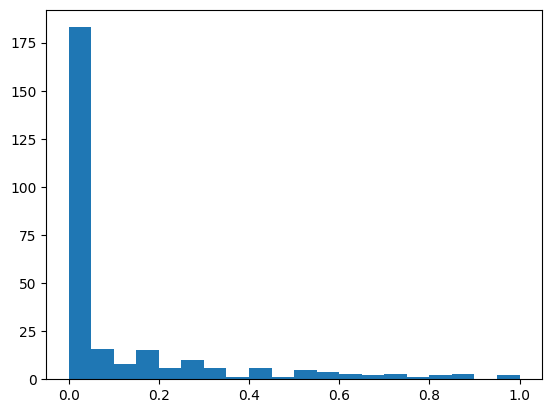

In [59]:
### plot historam of norm_y
plt.hist(norm_y, bins=20)
plt.show()


In [75]:
print(len(x), len(y))

500 500


In [78]:
### create round_y that rounds each value of y to the nearest 2 decimal
round_y = []
for i in y:
    round_y.append(round(i, 2))

round_y

[1.01,
 257.05,
 1518204.95,
 0.86,
 0.91,
 153330.05,
 0.03,
 30097.93,
 2.41,
 20886575.6,
 10741968.87,
 10788724.01,
 1.04,
 0.51,
 15.85,
 14025226.73,
 5.63,
 7.08,
 0.38,
 321317.52,
 4.45,
 0.64,
 18.66,
 0.2,
 22006579.97,
 32292716.51,
 1.7,
 0.86,
 0.7,
 0.79,
 1.39,
 0.13,
 1077440.59,
 4742.36,
 1465.2,
 0.51,
 13303615.46,
 7.42,
 155420.1,
 0.48,
 10012152.54,
 0.39,
 0.01,
 0.51,
 18.24,
 1464419.06,
 2049.39,
 251.72,
 34582445.23,
 139.49,
 1467.27,
 0.07,
 11846309.38,
 0.14,
 15858033.13,
 0.41,
 14190.95,
 57.63,
 0.55,
 775.65,
 3111.98,
 1.87,
 37036.67,
 1.12,
 17379038.13,
 2219931.1,
 1.8,
 6138484.26,
 0.24,
 1.9,
 24536034.51,
 2926086.05,
 0.67,
 38330114.32,
 0.86,
 10543.56,
 41140.29,
 226987.56,
 0.79,
 2739169.49,
 38910223.8,
 6817951.47,
 0.65,
 17778.36,
 26543552.54,
 2379.99,
 1654403.77,
 110846.05,
 199701.29,
 27252547.88,
 90609.09,
 122774.21,
 0.88,
 3684.69,
 9.95,
 31623443.84,
 51161.16,
 0.45,
 228.08,
 5162776.57,
 18.66,
 8.46,
 725249

In [82]:
prim_alg = prim.Prim(x, full_y, threshold=0.8, peel_alpha=0.1)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [83]:
b = prim_alg.find_box()


[MainProcess/INFO] 500 points remaining, containing 277 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.178, coverage: 0.3212996389891697, density: 1.0 restricted_dimensions: 3


In [96]:
print(len(b.box_lims))
b.box_lims[16]




17


,x101,x102,x11,x12,x21,x22,x31,x32,x41,x51,x52,x61,x62,x81,x82,x91,x92
0,111.111913,0.004558,0.000841,0.000279,0.000276,0.000214,0.000777,0.000789,0.000319,0.000899,0.000455,0.279159,0.001129,1.007454,1.007589,0.041002,0.000109
1,199.890808,199.810802,0.499802,0.499600,0.099924,0.099883,0.499297,0.499717,0.899715,0.499898,0.499312,0.799392,0.799793,9.984234,9.992969,0.099948,0.099834


In [85]:
### Create a new set of experiments that are within the box limits and rerun the model with these experiments




KeyError: "None of [Int64Index([  9,  10,  11,  19,  24,  25,  32,  36,  48,  54,  62,  64,  65,\n             67,  71,  73,  79,  81,  84,  95,  99, 102, 105, 106, 108, 118,\n            120, 121, 124, 128, 130, 136, 141, 142, 143, 145, 148, 158, 160,\n            166, 179, 183, 184, 189, 191, 206, 212, 219, 225, 230, 236, 238,\n            242, 261, 272, 273, 284, 288, 289, 297, 298, 302, 306, 314, 318,\n            319, 322, 330, 340, 353, 354, 355, 358, 363, 366, 369, 417, 418,\n            438, 443, 451, 454, 460, 464, 466, 472, 480, 484, 485],\n           dtype='int64')] are in the [columns]"

(array([14., 12., 19., 17., 20., 24., 30., 36., 33., 36.]),
 array([  0.40027761,  20.34933068,  40.29838374,  60.24743681,
         80.19648987, 100.14554294, 120.09459601, 140.04364907,
        159.99270214, 179.94175521, 199.89080827]),
 <BarContainer object of 10 artists>)

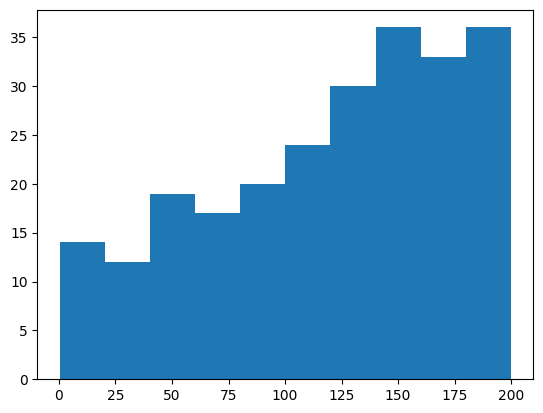

In [12]:
### get a list of indexes of y that are true
idx = []
for i in range(len(y)):
    if y[i] == True:
        idx.append(i)

#idx
### plot a histogram of experiments['x101'] that are in the idx list
plt.hist(experiments['x101'][idx])



In [13]:
### calculate the entropy of each x101 values for the idx list
from scipy.stats import entropy

### calculation the entropy of each value in experiments for the idx list
entropies = []
for i in experiments.keys():
    ### if i begins with 'x' then calculate the entropy
    if i[0] == 'x':
        entropies.append(entropy(experiments[i][idx]))

entropies

[5.356140146414289,
 5.325436954931442,
 5.289765255641403,
 5.288080989806036,
 5.320694032805698,
 5.282551190435092,
 5.263477572614006,
 5.282662527332789,
 5.299606946551037,
 5.271830752776906,
 5.282164134411323,
 5.354804725945364,
 5.328095393437925,
 5.352585852819303,
 5.36062640692033,
 5.367846444576175,
 5.324643056529437]

In [14]:
### create a hash of the input values from experiments
hashes = []
for i in range(len(experiments)):
    hashes.append(hash(experiments.iloc[i].values.tolist().__str__()))

### print any hashes that are the same
for i in range(len(hashes)):
    for j in range(i+1, len(hashes)):
        if hashes[i] == hashes[j]:
            print(i, j)